<a href="https://colab.research.google.com/github/sjbaek12/sjbaek12.github.io/blob/master/%ED%85%8C%EC%8A%A4%ED%8A%B8_%EA%B0%95%ED%99%94%ED%95%99%EC%8A%B5%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

어떤 상태에서 특정한 액션을 취하면 리워드가 발생한다.
정책신경망에서 어떤 상태일때 액선이 산출되고 그 산출로 인한 리워드가 최대가 되도록 정책신경망의 가중치를 조정한다. 그러면 리워드가 최대가 되는 액션을 산출하는 정책신경망이 될 것이다. 

loss함수는 리워드가 최대가 되는 액션을 산출했을 때, 마이너스 무한대가 되도록 조정하면 된다. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

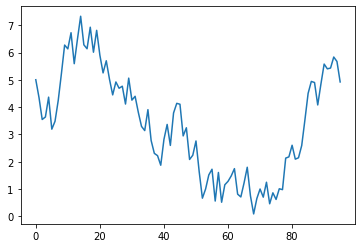

In [56]:
# 환경 모듈

def env():
  start_price = 3
  pricej=[]
  for i in range(100):
    change = np.random.rand(1)*1.2
    direction = np.random.choice(2, p=[0.5, 0.5])
    if direction == 1:
      if start_price - change[0] <= 0:
         p = 1.0
      else:
         p = start_price - change[0]     
    else: 
      p = start_price + change[0] 
    start_price = p
    pricej.append(p)
#  p_mean = np.mean(price)
#  p_std = np.std(price)
#  price = (price - p_mean)/p_std
  
  p_serise= []
  for i in range(96):
    serise = [pricej[i],pricej[i+1], pricej[i+2], pricej[i+3], pricej[i+4]]
    serise = np.array(serise)
    p_serise.append(serise)
  p_serise= p_serise[0:100]
  p_serise = np.array(p_serise)
  p_serise_lstm = p_serise.reshape(96, 5, 1)  # p_serise의 길이는 46이다. LSTM을 사용할 때 데이터 input 형태
  price_lstm = pricej[4:]
  price_lstm = np.array(price_lstm)
  return p_serise, p_serise_lstm, price_lstm 

p_serise, p_serise_lstm, price_lstm = env()
plt.plot(price_lstm)
plt.show()

In [ ]:
p_serise_lstm.shape

(46, 5, 1)

In [ ]:
price_data = [p_serise_lstm[j] for j in range(5)] 
price_data = np.array(price_data)
price_data.shape

(5, 5, 1)

In [ ]:
price_lstm[-1]

4.026364234027149

여기부터 정책신경망 이다.

In [3]:
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
import keras.layers as layers
from keras.layers import LSTM, Dense, Dropout
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras.initializers import glorot_uniform
from keras.callbacks import ModelCheckpoint, EarlyStopping
import keras.backend as K  # 케라스의 backend를 K. 형식으로 호출하는 것이고 여기서는 tensorflow이다.

In [46]:
def get_policy_model(lr):
  inp_L = layers.Input(shape=(7,1))  # 타입스텝수 5개, 특성개수 1개
  dense_L = LSTM(10)(inp_L)
  dense_L = Dense(64)(dense_L) 
  dense2 = Dropout(0.5)(dense_L)
  dense_L = Dense(64)(dense_L)
  output_s = layers.Dense(2, activation="sigmoid",kernel_initializer=glorot_uniform(seed=42), use_bias=False, kernel_regularizer=keras.regularizers.l2(0.001), name="out")(dense_L)

  def custom_loss(y_true, y_pred):
    log_lik = K.log(y_pred + 1e-10)*y_true
    return K.mean(log_lik, keepdims=True)



  model_train = Model(inputs=inp_L, outputs = output_s)
  model_train.compile(loss=custom_loss, optimizer=Adam(lr), metrics = ['mae'])
  return model_train 

In [47]:
model_train = get_policy_model(0.01)

In [48]:
model_train.summary()

Model: "functional_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 7, 1)]            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 10)                480       
_________________________________________________________________
dense_12 (Dense)             (None, 64)                704       
_________________________________________________________________
dense_13 (Dense)             (None, 64)                4160      
_________________________________________________________________
out (Dense)                  (None, 2)                 128       
Total params: 5,472
Trainable params: 5,472
Non-trainable params: 0
_________________________________________________________________


In [7]:
#정책망이 예측한 대로 action을 선택한다.

def action_choice(p_serise_lstm):
  act = model_train.predict(p_serise_lstm)
  #act = np.argmax(act)
  return act

In [8]:
# action_choice가 선택한 행동을 balance에 대비해서 가능한 행동인지 점검하고 틀린 경우 가능한 액션을 제시한다.
# 당초 0 매수, 1 매도를 --> 0 매수, 1 hold, 2 매도로 전환 
# 그리고 현재의 밸러스는 before 밸런스로 기록을 남긴다.

def action_validate(act, price, balance):
  if act == 0:
    if balance[0] - price < 0:
      act_v = 1
    else:
      act_v = 0
        
  if act == 1:
    if balance[2] > 0 :
      act_v = 2
    else:
      act_v = 1

  before_act_balance = [balance[0], balance[1], balance[2]] 

  return act_v, before_act_balance

In [9]:
# 검증이 완료된 행동으로 현재 밸런스를 갱신하고, 현재 가치를 구한다.

def balance_update(balance, price, act_v):
  if act_v == 0:
    balance[0] = balance[0] - price
    balance[1] = price
    balance[2] = balance[2] + 1
  if act_v == 1:
    balance[1] = price
  if act_v == 2:
    balance[0] = balance[0] + price
    balance[1] = price
    balance[2] = balance[2] -1
  balance_updated = [balance[0], balance[1], balance[2]] 
  present_value = balance[0] + balance[1] * balance[2]
  return balance_updated, present_value

In [10]:
# 이전의 밸런스와 현재 밸런스와의 비율을 구한다. 이것은 포트폴리오 가치비율이라고 한다

def pv_ratio_cal(before_act_balance, balance_updated):
  pv_ratio = (balance_updated[0] + balance_updated[1] * balance_updated[2])/(before_act_balance[0] + before_act_balance[1] * before_act_balance[2])
  return pv_ratio

In [11]:
# 주식보유 비율을 구한다.

def hold_ratio_cal(balance_updated, price):
  hold_ratio = balance_updated[2] / (present_value / price)

  return hold_ratio


In [12]:
# delayed reward를 구하기 위해서 기준 포트폴리오와 현재 밸런스의 비율을 구하고, 타겟 비율을 넘는지 확인한다.
# 만약 target을 넘으면 base_pv를 present_value를 변경한다.

def base_to_cur (base_pv, present_value, target_ratio):
  delay_ratio = (present_value - base_pv) / base_pv
  if delay_ratio > target_ratio:
    target = 1
    base_pv = present_value

  elif (-1 * delay_ratio) > target_ratio:
    target = -1
    base_pv = present_value
    
  else:
    target = 0
    base_pv = base_pv
    
  return delay_ratio, target, base_pv

In [13]:
# 거래와 관련된 모든 것을 기록한다.

def record(i, price, act, act_v, balance_updated, present_value, pv_ratio, hold_ratio, delay_ratio, target, base_pv):

  transaction_history.append([i, price, act, act_v, balance_updated, present_value, pv_ratio, hold_ratio, delay_ratio, target, base_pv])
  return transaction_history

In [43]:
# 학습을 위한 배치 데이터를 만든다.

def get_batch(transaction_history, target):


  for i in range(len(transaction_history)):

    y = np.full((len(transaction_history), 2), 0.0) 
    for j in range(i+1):
      k = transaction_history[j][2] # k는 당초 신경망이 추천한 값으로 0구매, 1는 매도 이다. 
      y[j,k] = (target + 1.0) / 2 
      
    price_data = [p_serise_lstm[j] for j in range(i+1)]
    delay_ratios = [transaction_history[j][8] for j in range(i+1)]
    hold_ratios = [transaction_history[j][7] for j in range(i+1)]
      
    train_input =[]
    for pd, dr, hr in zip(price_data, delay_ratios, hold_ratios):
      pd = np.append(pd, dr)
      pd = np.append(pd, hr)
      train_input.append(pd)
    train_input = np.array(train_input)
    train_input = train_input.reshape(-1,7,1)

  return y, train_input


여기부터는 학습의 영역이다.

In [57]:
# random action과 신경망의 선택 action을 조정해야 한다.


num_episode = 0.0
num_episodes = 100.0

target_ratio = 0.05
max_batch_size = 46
epsilon = 0.5


while num_episode < num_episodes:

  balance = [20, 0, 0]
  base_pv = 20
  
  history_record = []
  transaction_history=[]

  for i in range(len(p_serise_lstm)):
   
    price = p_serise_lstm[i][4]

    if np.random.rand() < epsilon :
      act = np.random.choice(2, p=[0.5, 0.5])
    else:
      act =  np.argmax(action_choice(p_serise_lstm)[i])
   
    act_v, before_act_balance = action_validate(act, price, balance)
    
    balance_updated, present_value = balance_update(balance, price, act_v)
    pv_ratio = pv_ratio_cal(before_act_balance, balance_updated)
    hold_ratio = hold_ratio_cal(balance_updated, price)
   
    delay_ratio, target, base_pv = base_to_cur(base_pv, present_value, target_ratio)
  
    transaction_history = record(i, price, act, act_v, balance_updated, present_value, pv_ratio, hold_ratio, delay_ratio, target, base_pv)



    if (target == 1 or target == -1):
      y, train_input = get_batch(transaction_history, target)
#      print(train_input.shape)
#      print(input("check?"))

      y = np.array(y)
      loss = model_train.train_on_batch(train_input, y)
      

      history_record.append(transaction_history)
      transaction_history=[]
      continue

    if i == (len(p_serise_lstm)-1):

      history_record.append(transaction_history)
      transaction_history=[]      

    
  if present_value > 50.0:
    break
  if (num_episode+1) % 2 == 0:
    print("num_episode: ",num_episode+1, "loss: ", loss[0], "mse :", loss[1], "wealth:", present_value)

  num_episode += 1.0
  epsilon = epsilon * ( 1 - num_episode/num_episodes)








    

In [ ]:
transaction_history

[]

In [58]:
history_record[-1]

[[91,
  array([5.40271782]),
  0,
  1,
  [array([1.07115671]), array([5.40271782]), 10],
  array([55.09833492]),
  array([0.96921859]),
  array([0.98055918]),
  array([-0.03078141]),
  0,
  array([56.84820257])],
 [92,
  array([5.43146802]),
  0,
  1,
  [array([1.07115671]), array([5.43146802]), 10],
  array([55.3858369]),
  array([1.00521798]),
  array([0.9806601]),
  array([-0.02572404]),
  0,
  array([56.84820257])],
 [93,
  array([5.83579513]),
  0,
  1,
  [array([1.07115671]), array([5.83579513]), 10],
  array([59.42910802]),
  array([1.0730019]),
  array([0.98197589]),
  array([0.04539995]),
  0,
  array([56.84820257])],
 [94,
  array([5.67340558]),
  0,
  1,
  [array([1.07115671]), array([5.67340558]), 10],
  array([57.80521249]),
  array([0.97267508]),
  array([0.98146955]),
  array([0.01683448]),
  0,
  array([56.84820257])],
 [95,
  array([4.92283775]),
  0,
  1,
  [array([1.07115671]), array([4.92283775]), 10],
  array([50.2995342]),
  array([0.87015568]),
  array([0.9787044

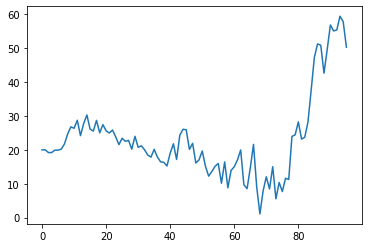

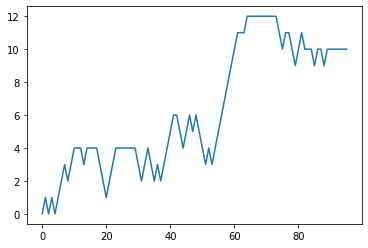

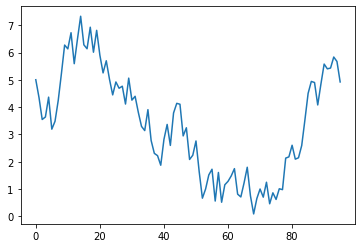

In [59]:
fk = np.array(history_record)
fkn = []
for i in range(len(fk)):
  for j in range(len(fk[i])):
    fkn.append(fk[i][j]) 

wealth = []
for i in range(len(fkn)):
  wealth.append(fkn[i][5])

stock = []
for i in range(len(fkn)):
  stock.append(fkn[i][4][2])

plt.plot(wealth)
plt.show()

plt.plot(stock)
plt.show()

plt.plot(price_lstm)
plt.show()

결전 테스트 테스트 테스트

In [ ]:
y = np.full((5, 2), 0.5)
y

array([[0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5]])

In [ ]:
kk = [1,0,1,0,1]
for i, k in enumerate(kk):
  y[i,k] = 1.0

y

array([[0.5, 1. ],
       [1. , 0.5],
       [0.5, 1. ],
       [1. , 0.5],
       [0.5, 1. ]])

In [ ]:
x = [np.array([5.0, 7.0]), np.array([6.0, 3.0]), np.array([2.0, 9.0]), np.array([5.0, 2.0]), np.array([3.0, 5.0])]
x = np.array(x)
x

array([[5., 7.],
       [6., 3.],
       [2., 9.],
       [5., 2.],
       [3., 5.]])

In [ ]:
from tensorflow import keras
import keras.layers as layers
from keras.layers import LSTM, Dense
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop

In [ ]:
inp = layers.Input(shape=(2,))
dense = Dense(3)(inp)
outs = layers.Dense(2, activation="sigmoid")(dense)

model_x = Model(inputs=inp, outputs = outs)
model_x.compile(loss='mse', optimizer=Adam(0.01), metrics = ['mae'])
model_x.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 9         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 8         
Total params: 17
Trainable params: 17
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_x.fit(x, y, epochs=30)

In [ ]:
model_x.predict(x)

array([[0.78012174, 0.9855293 ],
       [0.79271334, 0.25399655],
       [0.6218713 , 0.9998754 ],
       [0.7299584 , 0.2071917 ],
       [0.6393355 , 0.9756839 ]], dtype=float32)

여기가 끝이다.

In [ ]:
aj = np.array([[0.5, 0.5], [0.5,0.7]])

aj[0,0] = 1.0

aj

array([[1. , 0.5],
       [0.5, 0.7]])

In [ ]:
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
y_encoded = keras.utils.to_categorical(action, 2) # 분류 갯수를 정하기 위한 인수(2)가 필요하다.

In [ ]:
def balance_update(predict, p_serise):

  acts = []
  balance = [100, 0, 0]  #[자본금, 종가, 보유주식수] 이다.
  blist = [[100.0, 0.0, 0.0]]
  for i in range(len(predict)):
    action = np.random.choice(3,p=predict[i]) # 대안 중에서 하나를 선택한다. 
    
    if action == 0 and (balance[0] - p_serise[i][4]) < 0:
      ps = predict[i][1] + predict[i][2]
      pn = [predict[i][1],predict[i][2]]/ps
      action = 1+ np.random.choice(2,p=pn) 

    if action == 2 and balance[2] <= 0:
      ps = predict[i][0] + predict[i][1]
      pn = [predict[i][0],predict[i][1]]/ps
      action = np.random.choice(2,p=pn)  

    if action == 1:  # hold
      balance[1] = p_serise[i][4]

    if action  == 0:  # buy
      balance[0] = balance[0] - p_serise[i][4]
      balance[1] = p_serise[i][4]
      balance[2] = balance[2] + 1

    if action  == 2:
      balance[0] = balance[0] + p_serise[i][4]
      balance[1] = p_serise[i][4]
      balance[2] = balance[2] - 1 
     
    blist.append([balance[0], balance[1], balance[2]])
    acts.append(action)
  return blist, acts

In [ ]:
def reward_portfolio (blist):   

  reward_sum_list=[]
  reward_list=[]
   

  for a in blist:
    reward_sum = a[0] + a[1] * a[2]
    reward_sum_list.append(reward_sum)

  for i in range(len(reward_sum_list)-1):
    reward = np.abs(reward_sum_list[i+1] - reward_sum_list[i]) # 가중치를 일괄적으로 양 수로 만들어서 손실함수 계산의 방향을 일관되게 만든다.
    reward_list.append(reward)      
  return reward_sum_list, reward_list



In [ ]:
def discount_rewards(r, gamma=0.5):
    """Takes 1d float array of rewards and computes discounted reward
    e.g. f([1, 1, 1], 0.99) -> [2.9701, 1.99, 1]
    """
    prior = 0
    out = []
    r = r[::-1]
    for val in r:
        new_val = val + prior * gamma
        out.append(new_val)
        prior = new_val
    return np.array(out[::-1])

In [ ]:
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
import keras.layers as layers
from keras.layers import LSTM, Dense
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras.initializers import glorot_uniform
from keras.callbacks import ModelCheckpoint, EarlyStopping
import keras.backend as K  # 케라스의 backend를 K. 형식으로 호출하는 것이고 여기서는 tensorflow이다.

Using TensorFlow backend.


In [ ]:
def get_policy_model(lr):
  inp_L = layers.Input(shape=(5,),name="input_L")
  multip = layers.Input(shape=[1], name="advantages")
  dense_L = Dense(64)(inp_L)
  output_s = layers.Dense(3, activation="softmax",kernel_initializer=glorot_uniform(seed=42), use_bias=False, kernel_regularizer=keras.regularizers.l2(0.001), name="out")(dense_L)

  model_train = Model(inputs=[inp_L, multip], outputs = output_s)

  # loss 함수를 actual과 predict가 같을때 -무한대가 되도록 만든다. 완전히 틀리면 0 이므로 loss 함수의 값의 범위는 -무한대 ~ 0 이다.
  def custom_loss(y_true, y_pred):
    # actual: 0 predict: 0 -> log(0 * (0 - 0) + (1 - 0) * (0 + 0)) = -inf   log(0) = - inf
    # actual: 1 predict: 1 -> log(1 * (1 - 1) + (1 - 1) * (1 + 1)) = -inf   
    # actual: 1 predict: 0 -> log(1 * (1 - 0) + (1 - 1) * (1 + 0)) = 0      log(1) = 0
    # actual: 0 predict: 1 -> log(0 * (0 - 1) + (1 - 0) * (0 + 1)) = 0
    a = y_true * (y_true - y_pred) + (1 - y_true) * (y_true + y_pred)
    log_lik = K.log(a)
    return K.mean(log_lik * multip, keepdims=True)

  model_train.compile(loss=custom_loss, optimizer=Adam(lr), metrics = ['mae'])
  model_predict = Model(inputs=[inp_L], outputs = output_s)
  return model_train, model_predict

In [ ]:
model_train, model_predict = get_policy_model(0.00001)

In [ ]:
model_train.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_L (InputLayer)         (None, 5)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                384       
_________________________________________________________________
out (Dense)                  (None, 3)                 192       
Total params: 576
Trainable params: 576
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Setting up our environment

num_actions = 3
num_episode = 0
num_episodes = 10000

balance=[100.0, 0.0, 0.0]   

action_list = []
reward_list = []
reward_sum_list = []

price, p_serise, price_lstm = env()

while num_episode < num_episodes:

    losses = []
     
    p_serise = p_serise.astype(float) # nan 발생을 막기 위한 시도이다.

    predict = model_predict.predict(p_serise)  # 한개의 state를 input해서 신경망을 통해 action을 만들어낸다.
      
    blist, acts = balance_update(predict, p_serise)

    reward_sum_list, reward_list = reward_portfolio(blist)

   
    if reward_sum_list[-1] > 120.0:
      break
    else:
      y_encoded = keras.utils.to_categorical(acts, 3)
      dis_re = discount_rewards(reward_list)
      loss = model_train.train_on_batch([p_serise, dis_re/100], y_encoded)

    losses.append(loss)

    if (num_episode+1) % 100 == 0:
      print("num_episode: ",num_episode+1, "loss: ", losses[-1][0], "model_reward: ", reward_sum_list[-1])
          
    num_episode += 1
    price, p_serise, price_lstm = env()


num_episode:  100 loss:  -0.0015004296 model_reward:  98.43091745899021
num_episode:  200 loss:  0.005515466 model_reward:  100.0
num_episode:  300 loss:  0.00019470043 model_reward:  98.40993966995285
num_episode:  400 loss:  0.0054811565 model_reward:  100.0
num_episode:  500 loss:  0.0054636374 model_reward:  100.0
num_episode:  600 loss:  0.0054448424 model_reward:  100.0
num_episode:  700 loss:  0.005426042 model_reward:  100.0
num_episode:  800 loss:  0.0024502221 model_reward:  99.17197107528669
num_episode:  900 loss:  0.005381563 model_reward:  100.0
num_episode:  1000 loss:  -0.0010551126 model_reward:  98.56116042059348
num_episode:  1100 loss:  0.005335754 model_reward:  100.0
num_episode:  1200 loss:  0.0053128023 model_reward:  100.0
num_episode:  1300 loss:  0.0052875252 model_reward:  100.0
num_episode:  1400 loss:  0.005262426 model_reward:  100.0
num_episode:  1500 loss:  0.00523735 model_reward:  100.0
num_episode:  1600 loss:  0.0052127033 model_reward:  100.0
num_e

In [ ]:
predict = model_predict.predict(p_serise)

In [ ]:
predict

array([[3.6138725e-03, 9.9543518e-01, 9.5101329e-04],
       [2.5309306e-03, 9.9687552e-01, 5.9350801e-04],
       [1.6649085e-03, 9.9793869e-01, 3.9637886e-04],
       [1.1331739e-03, 9.9862301e-01, 2.4384700e-04],
       [8.9347886e-04, 9.9892789e-01, 1.7856655e-04],
       [6.7802204e-04, 9.9918562e-01, 1.3640364e-04],
       [5.1899574e-04, 9.9938595e-01, 9.5118827e-05],
       [4.0926790e-04, 9.9951863e-01, 7.2090930e-05],
       [3.4076688e-04, 9.9960107e-01, 5.8188223e-05],
       [2.9136828e-04, 9.9965870e-01, 4.9990009e-05],
       [2.4987900e-04, 9.9970716e-01, 4.2903313e-05],
       [2.4483568e-04, 9.9971491e-01, 4.0296556e-05],
       [2.2691984e-04, 9.9973422e-01, 3.8798502e-05],
       [2.2932976e-04, 9.9973351e-01, 3.7164038e-05],
       [2.3295525e-04, 9.9972624e-01, 4.0761293e-05],
       [2.3052981e-04, 9.9972850e-01, 4.1016719e-05],
       [2.7433300e-04, 9.9967790e-01, 4.7780799e-05],
       [2.9424176e-04, 9.9964762e-01, 5.8202586e-05],
       [3.4178881e-04, 9.995

In [ ]:
blist, acts = balance_update(predict, p_serise)

    

In [ ]:
acts

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [ ]:
blist

[[100.0, 0.0, 0.0],
 [100, 3.9877771384524716, 0],
 [100, 4.0765769672822, 0],
 [100, 4.210458646072498, 0],
 [100, 4.483095742634497, 0],
 [100, 4.565387372085023, 0],
 [100, 4.71244661397334, 0],
 [100, 4.885086273380034, 0],
 [100, 5.016812548642121, 0],
 [100, 5.048064792342275, 0],
 [100, 5.014176983045866, 0],
 [100, 5.112904769029705, 0],
 [100, 5.082847672344554, 0],
 [100, 5.16510696197368, 0],
 [100, 5.092284003497985, 0],
 [100, 4.948211285146682, 0],
 [100, 5.0063037357539795, 0],
 [100, 4.784278366930281, 0],
 [100, 4.760625085739134, 0],
 [100, 4.690961475596859, 0],
 [100, 4.460830067774835, 0],
 [100, 4.2789269692796275, 0],
 [100, 4.008987712574459, 0],
 [100, 3.874456053114483, 0],
 [100, 3.574380409350225, 0],
 [100, 3.3768865232630247, 0]]

In [ ]:
dis_re

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
reward_list

[0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.10798032990297202,
 0.0,
 0.09972510880207608,
 0.0,
 0.05702562077745199,
 0.0,
 0.0,
 0.0,
 0.0,
 0.008023248219004131,
 0.0,
 0.0,
 -0.21939723052554427,
 -0.2704698111146513,
 -0.21527481970460371,
 0.0,
 -0.380158586348756,
 0.0,
 0.0,
 0.0]

In [ ]:
test = [0.1, 0.2, 0.7]
print(test[0:2])

[0.1, 0.2]


In [ ]:
aa = np.random.choice(2,p=test[0:2])
print(aa)

ValueError: ignored

In [ ]:
def reward_lstm (p_serise, action):
  rewards =[0]
  
  for i in range(len(p_serise)-1):
    price_gap = p_serise[i+1][4] - p_serise[i][0]
    if price_gap >= 0 and action[i] == 1 :
       reward = 1
       rewards.append(reward)
    if price_gap >= 0 and action[i] == 0 :
       reward = 0
       rewards.append(reward)
    if price_gap >= 0 and action[i] == 2 :
       reward = -1
       rewards.append(reward)
    if price_gap <= 0 and action[i] == 1 :
       reward = -1
       rewards.append(reward)
    if price_gap <= 0 and action[i] == 0 :
       reward = 0
       rewards.append(reward)
    if price_gap <= 0 and action[i] == 2 :
       reward = 1
       rewards.append(reward)

  return rewards


In [ ]:
len(reward_lstm (p_serise, price_lstm_y))

25

In [ ]:
 def act_selection(act):
   acts = []
   for i in range(0, len(act)):
     action = np.random.choice(3,p=act[i])
     acts.append(action)
   return acts

In [ ]:
multip = np.array([1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1])
len(multip)

25

In [ ]:
predict = model_predict.predict(p_serise)

In [ ]:
action_c=[]

for i in range(len(predict)):
  a = np.argmax(predict[i])
  action_c.append(a)

In [ ]:
np.sum(reward_lstm(p_serise, action_c))

3

In [ ]:
action_c

[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1]

In [ ]:
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
import tensorflow as tf
import keras.layers as layers
from keras.layers import LSTM, Dense
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras.initializers import glorot_uniform
from keras.callbacks import ModelCheckpoint, EarlyStopping
import keras.backend as K  # 케라스의 backend를 K. 형식으로 호출하는 것이고 여기서는 tensorflow이다.

Using TensorFlow backend.


In [ ]:
#inp_L = layers.Input(shape=(5,1),name="input_L")  # LSTM 용
#dense_L = LSTM(5, return_sequences=False)(inp_L)  # LSTM 용
inp_L = layers.Input(shape=(5,),name="input_L")
#dense_L = Dense(64)(dense_L)
dense_L = Dense(64)(inp_L)
#output_L = Dense(1)(dense_L)
output_s = layers.Dense(3, activation="softmax",kernel_initializer=glorot_uniform(seed=42), use_bias=False, kernel_regularizer=keras.regularizers.l2(0.001), name="out")(dense_L)

model_lstm = Model(inputs=inp_L, outputs = output_s)

In [ ]:
optimizer = tf.keras.optimizers.Adam(lr=0.001)
model_lstm.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['mae'])

In [ ]:
history_lstm = model_lstm.fit(p_serise, y_encoded, epochs=150, verbose=0)

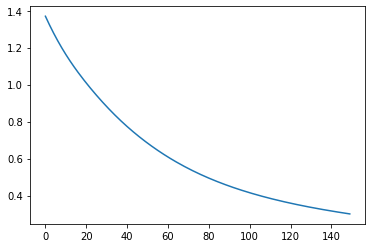

In [ ]:
plt.plot(history_lstm.history['loss'])
plt.show()

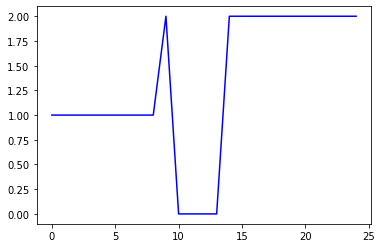

In [ ]:
plt.plot(action(model_lstm.predict(p_serise)), 'b')
# plt.plot(price_lstm_y, 'r')
plt.show()

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


만약 정책함수에서 softmax가 행동대안을 산출하면 각 행동대안이 갖는 확률을 기반으로 하여 새로운 행동을 산출한다. 만약 각 행동대안의 확율이 높아 질 수록 산출할 행동 대안의 모습은 수렴해 갈 것이다.

custom loss 함수를 테스트 해본다.

Using TensorFlow backend.


In [ ]:
def my_loss(y_true, y_pred):
  y_true = y_true **2
  y_pred = y_pred **2
  loss = K.mean(K.abs(y_true - y_pred) + K.square(y_true - y_pred))
  return loss * multip


# metric는 중요하지 않다.

def my_metric(y_true, y_pred):
  return K.mean(K.abs(y_true - y_pred)) * 1000

In [ ]:
# 하나의 에피소드 내에서 지연된 보상을 하기 위한 방법이다. 

def discount_rewards(r, gamma=0.99):
    """Takes 1d float array of rewards and computes discounted reward
    e.g. f([1, 1, 1], 0.99) -> [2.9701, 1.99, 1]
    """
    prior = 0
    out = []
    r = r[::-1]
    for val in r:
        new_val = val + prior * gamma
        out.append(new_val)
        prior = new_val
    return np.array(out)

In [ ]:
# test_set에 적용하는 함수

def score_model(model_predict, num_tests):
    scores = []    
    for num_test in range(num_tests):
        observation = env()
        forcasts = model_predict.predict(observation)
        rw = reward(observation, np.argmax(forcasts, axis=1))
        scores.append(rw)
    return np.mean(scores)